In [1]:
from mongo_wrapper.mongo_wrapper import MongoWrapper
import os
import spacy
from spacy.lang.es.stop_words import STOP_WORDS
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import nltk
from gensim import corpora, models
import string
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix
from gensim.matutils import Sparse2Corpus
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models
from collections import Counter, defaultdict
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity

load_dotenv()

True

In [2]:
# MongoDB setup
MONGO_IP = os.getenv("MONGO_IP")
MONGO_PORT = os.getenv("MONGO_PORT")
MONGO_DB = "news_outlets"
MONGO_USERNAME = os.getenv("MONGO_USERNAME")
MONGO_PASSWORD = os.getenv("MONGO_PASSWORD")

In [3]:
def combine(mcloud: pd.DataFrame, gnews: pd.DataFrame, state: str) -> pd.DataFrame:
    gnews['source'] = 'gnews'
    mcloud['source'] = 'mcloud'
    
    # Ensure all columns exist in both dataframes
    all_columns = set(gnews.columns) | set(mcloud.columns)
    for col in all_columns:
        if col not in gnews.columns:
            gnews[col] = None
        if col not in mcloud.columns:
            mcloud[col] = None
    
    # Combine the dataframes
    combined = pd.concat([gnews, mcloud], ignore_index=True)
    combined['year'] = combined['date'].dt.year
    
    # Filter for target years only (2020 and 2022)
    target_years = [2020, 2022]
    combined_filtered = combined[combined['year'].isin(target_years)]
    
    # Print summary for this state showing only 2020 and 2022
    print(f"\n{state} - Data summary (2020 & 2022 only):")
    
    for year in target_years:
        year_data = combined_filtered[combined_filtered['year'] == year]
        
        if not year_data.empty:
            mcloud_count = len(year_data[year_data['source'] == 'mcloud'])
            gnews_count = len(year_data[year_data['source'] == 'gnews'])
            total_count = len(year_data)
            
            print(f"  {year}:")
            print(f"    MediaCloud: {mcloud_count} articles")
            print(f"    Google News: {gnews_count} articles")
            print(f"    Total: {total_count} articles")
        else:
            print(f"  {year}: 0 articles")
    
    return combined

In [4]:
def get_state_data(state: str, mongo_client: MongoWrapper) -> tuple[list, list]:
    try:
        gnews_data = mongo_client.get_collection_entries(f'gnews_{state}')
    except Exception as e:
        print(f"  Error getting Google News data for {state}: {e}")
        gnews_data = []
    
    try:
        mcloud_data = mongo_client.get_collection_entries(f'mediacloud_{state}')
    except Exception as e:
        print(f"  Error getting MediaCloud data for {state}: {e}")
        mcloud_data = []
    
    return gnews_data, mcloud_data

In [5]:
def process_state_data(state: str, mongo_client: MongoWrapper) -> pd.DataFrame:
    print(f"\nProcessing {state}...")
    
    gnews, mcloud = get_state_data(state, mongo_client)
    gnews_df, mcloud_df = pd.DataFrame(gnews), pd.DataFrame(mcloud)
    
    # Skip if both dataframes are empty
    if gnews_df.empty and mcloud_df.empty:
        print(f"  No data found for {state}")
        return pd.DataFrame()
    
    # Process Google News data
    if not gnews_df.empty:
        try:
            gnews_df["date"] = pd.to_datetime(gnews_df["published date"], format='%a, %d %b %Y %H:%M:%S GMT')
            gnews_df = gnews_df.drop(columns=['published date'])
        except Exception as e:
            print(f"  Error processing Google News dates for {state}: {e}")
            gnews_df = pd.DataFrame()  # Empty if error
    
    # Process MediaCloud data
    if not mcloud_df.empty:
        try:
            mcloud_df['date'] = pd.to_datetime(mcloud_df['publish_date'])
            mcloud_df['date_str'] = mcloud_df['date'].dt.strftime('%a, %d %b %Y 08:00:00 GMT')
            mcloud_df['date'] = pd.to_datetime(mcloud_df['date_str'], format='%a, %d %b %Y %H:%M:%S GMT')
            mcloud_df = mcloud_df.drop(columns=['publish_date', 'date_str'])
        except Exception as e:
            print(f"  Error processing MediaCloud dates for {state}: {e}")
            mcloud_df = pd.DataFrame()  # Empty if error
    
    # Combine data if at least one source has valid data
    if not gnews_df.empty or not mcloud_df.empty:
        combined = combine(mcloud_df, gnews_df, state)
        return combined
    else:
        print(f"  No valid data after processing for {state}")
        return pd.DataFrame()

In [6]:
def filter_by_years(combined_df: pd.DataFrame, target_years: list = [2020, 2022]) -> dict:
    year_dfs = {}
    
    for year in target_years:
        year_data = combined_df[combined_df['year'] == year].copy()
        if not year_data.empty:
            year_dfs[year] = year_data
            print(f"    {year}: {len(year_data)} articles")
        else:
            print(f"    {year}: 0 articles")
    
    return year_dfs

In [7]:
def main():
    mongo_client = MongoWrapper(
        db=MONGO_DB,
        user=MONGO_USERNAME,
        password=MONGO_PASSWORD,
        ip=MONGO_IP,
        port=MONGO_PORT
    )
    
    # All Mexican states
    states = [
        "Aguascalientes", "Baja California", "Baja California Sur", "Campeche", "Chiapas", "Chihuahua",
        "Coahuila", "Colima", "Durango", "Guanajuato", "Guerrero", "Hidalgo", "Jalisco", "Mexico",
        "Michoacan", "Morelos", "Nayarit", "Nuevo Leon", "Oaxaca", "Puebla", "Queretaro", "Quintana Roo",
        "San Luis Potosi", "Sinaloa", "Sonora", "Tabasco", "Tamaulipas", "Tlaxcala", "Veracruz",
        "Yucatan", "Zacatecas", "Ciudad de México"]
    
    target_years = [2020, 2022]
    state_year_dfs = {}
    
    print("Starting processing of all Mexican states...")
    print(f"Target years: {target_years}")
    
    for state in states:
        combined_df = process_state_data(state, mongo_client)
        
        if not combined_df.empty:
            # Filter by years and create separate dataframes
            year_dfs = filter_by_years(combined_df, target_years)
            
            # Store in the main dictionary with state_year keys
            for year, year_df in year_dfs.items():
                state_year_key = f"{state}_{year}"
                state_year_dfs[state_year_key] = year_df
        else:
            print(f"  No data to process for {state}")
    
    return state_year_dfs

if __name__ == "__main__":
    state_year_dfs = main()

2025-05-25 22:35:37,357 WARNING Logger Mongo was configured with True console stream
2025-05-25 22:35:37,702 INFO Connected to news_outlets database on 206.81.16.39


Starting processing of all Mexican states...
Target years: [2020, 2022]

Processing Aguascalientes...

Aguascalientes - Data summary (2020 & 2022 only):
  2020:
    MediaCloud: 2000 articles
    Google News: 2014 articles
    Total: 4014 articles
  2022:
    MediaCloud: 1998 articles
    Google News: 2462 articles
    Total: 4460 articles
    2020: 4014 articles
    2022: 4460 articles

Processing Baja California...

Baja California - Data summary (2020 & 2022 only):
  2020:
    MediaCloud: 2000 articles
    Google News: 2069 articles
    Total: 4069 articles
  2022:
    MediaCloud: 3995 articles
    Google News: 3010 articles
    Total: 7005 articles
    2020: 4069 articles
    2022: 7005 articles

Processing Baja California Sur...

Baja California Sur - Data summary (2020 & 2022 only):
  2020:
    MediaCloud: 3000 articles
    Google News: 926 articles
    Total: 3926 articles
  2022:
    MediaCloud: 1998 articles
    Google News: 2163 articles
    Total: 4161 articles
    2020: 3926

In [8]:
lemm = spacy.load('es_core_news_md')

custom_stopwords = {
    'él', 'ella', 'ellos', 'ellas', 'le', 'la', 'lo', 'les', 'las', 'los', 'sino', 'querétaro', 
    'año', 'mes', 'día', 'tiempo', 'momento', 'semana', '2020', '2021', '2022', '2023', '2024', '2025', 'méxico',
    'mil', 'ciento', 'millón', 'dólares', 'tener', 'hacer', 'ver', 'ir', 'llegar', 'mexicano',
    'salir', 'seguir', 'entre', 'sobre', 'tras', 'mediante', 'durante', 'aunque', 'ciudad',
    'nacional', 'persona', 'caso', 'entidad', 'the', 'país', 'público', 'general', 'lópez',
    'gobierno', 'presidente', 'chihuahua', 'california', 'león', 'durango', 'coahuila', 'puebla', 
    'luis', 'san', 'roo', 'veracruz', 'aguascalientes', 'baja', 'sur', 'potosí', 'sinaloa',
    'campeche', 'chiapas', 'colima', 'estado', 'guanajuato', 'ciudad', 'estado', 'quintana',  
    'guerrero', 'hidalgo', 'jalisco', 'michoacán', 'morelos', 'nayarit', 'nuevo león', 
    'sonora', 'tabasco', 'tamaulipas', 'tlaxcala', 'yucatán', 'zacatecas', 'oaxaca'
}

ALL_STOP_WORDS = STOP_WORDS.union(custom_stopwords)

def preprocess(text):
    # lowercase 
    text = text.lower()
    # process with spacy
    doc = lemm(text)
    tokens = [
        token.lemma_ for token in doc 
        if token.lemma_ not in ALL_STOP_WORDS                  # remove stop words (default and custom)
        and not token.is_punct                                 # remove punctuation
        and not token.is_digit                                 # remove numbers 
        and not any(char.isdigit() for char in token.text)     # remove tokens with digits (e.g., tokens with hyphen dividing numbers)
        and len(token.lemma_.strip()) > 2                      # remove short tokens
        and token.lemma_.strip() != '']                        # remove empty tokens
    return " ".join(tokens)

# STEP 1: Clean all dataframes
state_year_dfs_cleaned = {}

for state_year_key, df in state_year_dfs.items():
    try:  
        # copy of the original dataframe
        df_cleaned = df.copy()
        # preprocess the content column
        df_cleaned['text_cleaned'] = df_cleaned['content'].astype(str).apply(preprocess)
        # count the number of words
        df_cleaned['word_count'] = df_cleaned['text_cleaned'].apply(lambda x: len(x.split()))
        # remove articles that are too short
        df_cleaned = df_cleaned[df_cleaned['word_count'] >= 10]
        # save in dictionary
        state_year_dfs_cleaned[state_year_key] = df_cleaned
        print(f"Completed {state_year_key}: {len(df_cleaned)} articles remaining")
    except Exception as e:
        print(f"Error with {state_year_key}: {e}")

Completed Aguascalientes_2020: 1765 articles remaining
Completed Aguascalientes_2022: 3524 articles remaining
Completed Baja California_2020: 1960 articles remaining
Completed Baja California_2022: 5483 articles remaining
Completed Baja California Sur_2020: 689 articles remaining
Completed Baja California Sur_2022: 3246 articles remaining
Completed Campeche_2020: 928 articles remaining
Completed Campeche_2022: 2821 articles remaining
Completed Chiapas_2020: 2223 articles remaining
Completed Chiapas_2022: 4317 articles remaining
Completed Chihuahua_2020: 2870 articles remaining
Completed Chihuahua_2022: 4511 articles remaining
Completed Coahuila_2020: 1657 articles remaining
Completed Coahuila_2022: 4482 articles remaining
Completed Colima_2020: 1171 articles remaining
Completed Colima_2022: 4702 articles remaining
Completed Durango_2020: 2465 articles remaining
Completed Durango_2022: 4527 articles remaining
Completed Guanajuato_2020: 2736 articles remaining
Completed Guanajuato_2022: 

In [9]:
# STEP 2: LDA analysis on all dataframes
lda_results = {}

for state_year_key, df in state_year_dfs_cleaned.items():
    try:
        # use the cleaned text
        texts = df['text_cleaned']
        # countervectorize the text
        cv = CountVectorizer(ngram_range=(1, 3), lowercase=False, min_df=0.001, max_df=0.4, 
                             stop_words=list(ALL_STOP_WORDS), token_pattern=r'\b[a-záéíóúñü]{3,}\b')
        cv.fit(texts)
        vectorized_text = cv.transform(texts)
        # convert dtm to the format required by gensim
        dtm_sparse = csr_matrix(vectorized_text)
        # convert sparse matrix to gensim corpus
        corpus = Sparse2Corpus(dtm_sparse, documents_columns=False)
        # create gensim dictionary from sklearn CountVectorizer vocabulary
        vocabulary_gensim = {}
        for key, val in cv.vocabulary_.items():  
            vocabulary_gensim[val] = key
        dictionary = corpora.Dictionary()
        dictionary.id2token = vocabulary_gensim
        dictionary.token2id = cv.vocabulary_
        
        # lda model
        lda_model = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=8, passes=15, random_state=42, eta=0.01) 
        lda_results[state_year_key] = {
            "model": lda_model,
            "corpus": corpus,
            "dictionary": dictionary}
        print(f"LDA for {state_year_key} completed")
    except Exception as e:
        print(f"error for {state_year_key}: {e}")

LDA for Aguascalientes_2020 completed
LDA for Aguascalientes_2022 completed
LDA for Baja California_2020 completed
LDA for Baja California_2022 completed
LDA for Baja California Sur_2020 completed
LDA for Baja California Sur_2022 completed
LDA for Campeche_2020 completed
LDA for Campeche_2022 completed
LDA for Chiapas_2020 completed
LDA for Chiapas_2022 completed
LDA for Chihuahua_2020 completed
LDA for Chihuahua_2022 completed
LDA for Coahuila_2020 completed
LDA for Coahuila_2022 completed
LDA for Colima_2020 completed
LDA for Colima_2022 completed
LDA for Durango_2020 completed
LDA for Durango_2022 completed
LDA for Guanajuato_2020 completed
LDA for Guanajuato_2022 completed
LDA for Guerrero_2020 completed
LDA for Guerrero_2022 completed
LDA for Hidalgo_2020 completed
LDA for Hidalgo_2022 completed
LDA for Jalisco_2020 completed
LDA for Jalisco_2022 completed
LDA for Mexico_2020 completed
LDA for Mexico_2022 completed
LDA for Michoacan_2020 completed
LDA for Michoacan_2022 completed


In [10]:
# STEP 3: Calculate topic shares
topic_shares = {}

for state_year_key, data in lda_results.items():
    model = data["model"]
    corpus = data["corpus"]
    
    topic_dist = np.zeros(model.num_topics)
    doc_count = 0
    for doc in corpus:
        doc_count += 1
        doc_topics = model[doc]
        for topic_id, prob in doc_topics:
            topic_dist[topic_id] += prob
    if doc_count > 0:
        topic_dist = topic_dist / doc_count
    topic_shares[state_year_key] = topic_dist

# STEP 4: Aggregate by year and save
target_years = [2020, 2022]

for year in target_years:
    # Get topic shares for this year
    year_topic_shares = {}
    for key, shares in topic_shares.items():
        if key.endswith(f'_{year}'):
            state_name = key.replace(f'_{year}', '')
            year_topic_shares[state_name] = shares
    
    if year_topic_shares:
        # Save topic shares
        df_shares_year = pd.DataFrame.from_dict(year_topic_shares, orient='index')
        df_shares_year.columns = [f'Topic_{i}' for i in range(df_shares_year.shape[1])]
        df_shares_year.to_csv(f'topic_shares_{year}_aggregated.csv')
        print(f"Topic shares for {year} saved ({len(year_topic_shares)} states)")

# STEP 5: Save keywords aggregated by year
for year in target_years:
    year_keywords = {}
    for state_year_key, data in lda_results.items():
        if state_year_key.endswith(f'_{year}'):
            state_name = state_year_key.replace(f'_{year}', '')
            model = data["model"]
            state_topics = {}
            for topic_id in range(model.num_topics):
                top_words = model.show_topic(topic_id, topn=15)
                words = [word for word, _ in top_words]
                state_topics[f'Topic_{topic_id}'] = ', '.join(words)
            year_keywords[state_name] = state_topics
    
    if year_keywords:
        df_keywords_year = pd.DataFrame.from_dict(year_keywords, orient='index')
        df_keywords_year.to_csv(f'topic_keywords_{year}_aggregated.csv')
        print(f"Topic keywords for {year} saved ({len(year_keywords)} states)")

Topic shares for 2020 saved (32 states)
Topic shares for 2022 saved (32 states)
Topic keywords for 2020 saved (32 states)
Topic keywords for 2022 saved (32 states)


In [14]:
df_keywords_year

Topic_0  \
Aguascalientes       banda, metal, álbum, paul, rock, música, tocar...   
Baja California      frío, lluvia, temperatura, viento, zona, ambie...   
Baja California Sur  delito, violencia, víctima, homicidio, proceso...   
Campeche             banda, metal, álbum, paul, rock, música, tocar...   
Chiapas              salud, social, federal, secretaría, estatal, s...   
Chihuahua            temperatura, frío, lluvia, norte, zona, mejora...   
Coahuila             saltillo, mujer, encontrar, autoridad, menor, ...   
Colima               seguridad, violencia, federal, grupo, cártel, ...   
Durango              calor, federal, temporada, seguridad, pan, can...   
Guanajuato           bravo, liga, oficial, detención, arma, colonia...   
Guerrero             periodista, derechos, derechos humanos, humano...   
Hidalgo              ron, frío, zona, norte, temperatura, ambiente,...   
Jalisco              zona, temperatura, frío, norte, lluvia, alto, ...   
Mexico               periodista, obrador, humanos, derechos, derech...   
Michoacan            iem, indígena, morena, recibir, reglamento, ho...   
Morelos              morelia, grupo, real, colonia, guadalupe, colo...   
Nayarit              banda, metal, álbum, paul, rock, música, tocar...   
Nuevo Leon           salud, reproducción, médico, atención, recomen...   
Oaxaca               electoral, gobernador, político, proceso, secr...   
Puebla               autoridad, vía, reportar, difundir, exigir, ta...   
Queretaro            estadio, tauro, violencia, autoridad, segurida...   
Quintana Roo         jornada, sociedad, internacional, seguridad, a...   
San Luis Potosi      mujer, seguridad, encontrar, fiscalía, autorid...   
Sinaloa              banda, metal, álbum, paul, rock, música, tocar...   
Sonora               película, historia, lugar, contar, encontrar, ...   
Tabasco              hijo, obrador, empresa, contrato, baker, beltr...   
Tamaulipas           partido, morena, gobernador, político, villarr...   
Tlaxcala             banda, metal, álbum, paul, música, rock, tocar...   
Veracruz             autoridad, seguridad, estatal, policía, fiscal...   
Yucatan              jornada, sociedad, sheinbaum, político, asegur...   
Zacatecas            partido, seguridad, deporte, político, violenc...   
Ciudad de México     sedés, salud, gratuito, atención, hospital, va...   

                                                               Topic_1  \
Aguascalientes       seguridad, partido, federal, pan, sánchez, mor...   
Baja California      paz, cabo, educación, josé, evento, cultura, c...   
Baja California Sur  pesos, precio, actividad, vehículo, encontrar,...   
Campeche             periodista, mayo, historia, cultura, hora, pla...   
Chiapas              migrant, municipio, tapachula, salud, migració...   
Chihuahua            estatal, mujer, municipio, seguridad, pesos, d...   
Coahuila             frío, temperatura, norte, zona, lluvia, racha,...   
Colima               pesos, ucrania, social, deber, servicio, traba...   
Durango              torneo, participación, liga, equipo, duranguen...   
Guanajuato           salud, educación, maestro, ssg, mayo ssg, estu...   
Guerrero             sismo, suscripción, magnitud, zona, sísmico, a...   
Hidalgo              electoral, gobernador, partido, político, fede...   
Jalisco              gente, martínez, tequila, claudio, jimeno, gen...   
Mexico               violencia, mujer, autoridad, seguridad, fiscal...   
Michoacan            grupo, cártel, cuerpo, autoridad, violencia, f...   
Morelos              seguridad, judicial, docente, cuernavaca, fede...   
Nayarit              hijo, empresa, playa, zona, vallarta, turístic...   
Nuevo Leon           fiscalía, encontrar, seguridad, autoridad, mun...   
Oaxaca               educación, pesos, servicio, municipio, program...   
Puebla               min, área, falta, centro, evento, recibir, act...   
Queretaro            cooki, sitio, web, sitio web, utilizar, exper

In [16]:
df_2020 = pd.read_csv('news_pipeline/keywords_2020.csv', index_col=0)
df_2022 = pd.read_csv('news_pipeline/keywords_2022.csv', index_col=0)

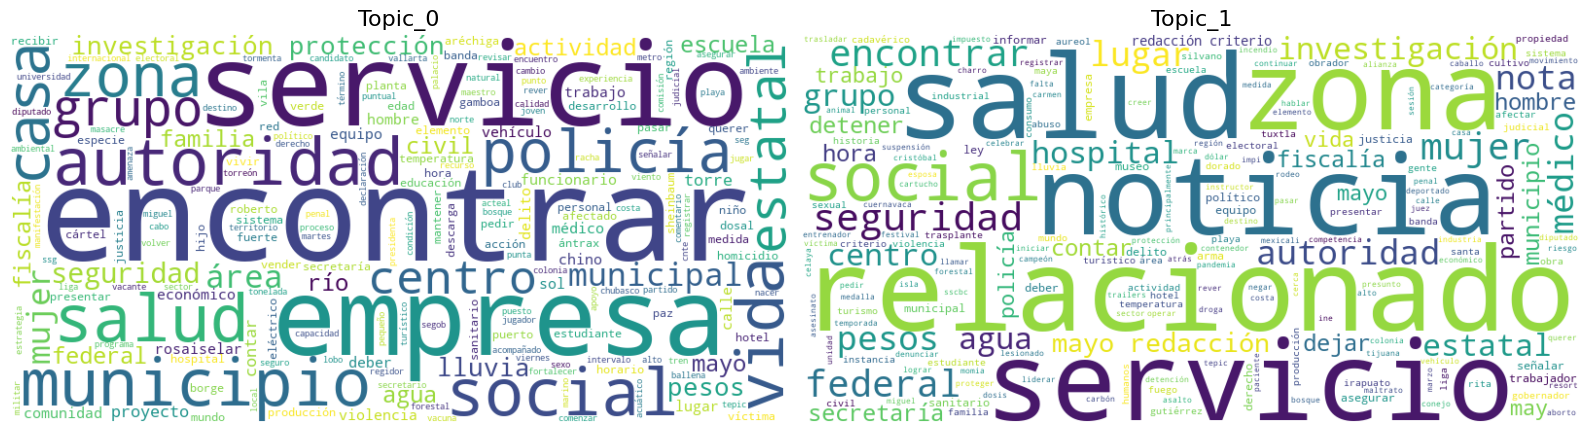

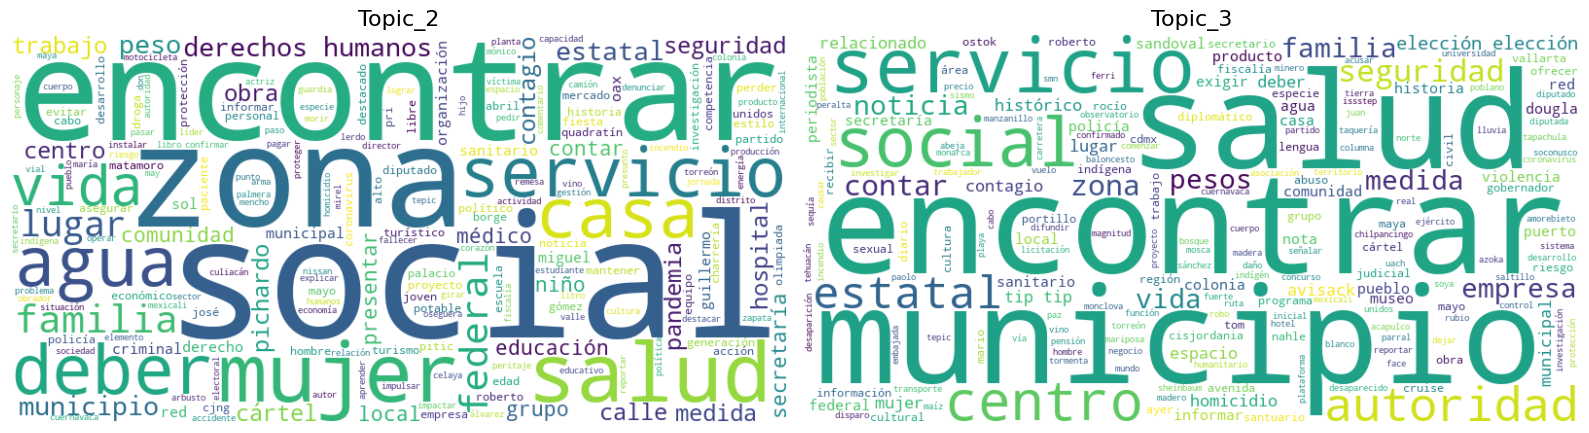

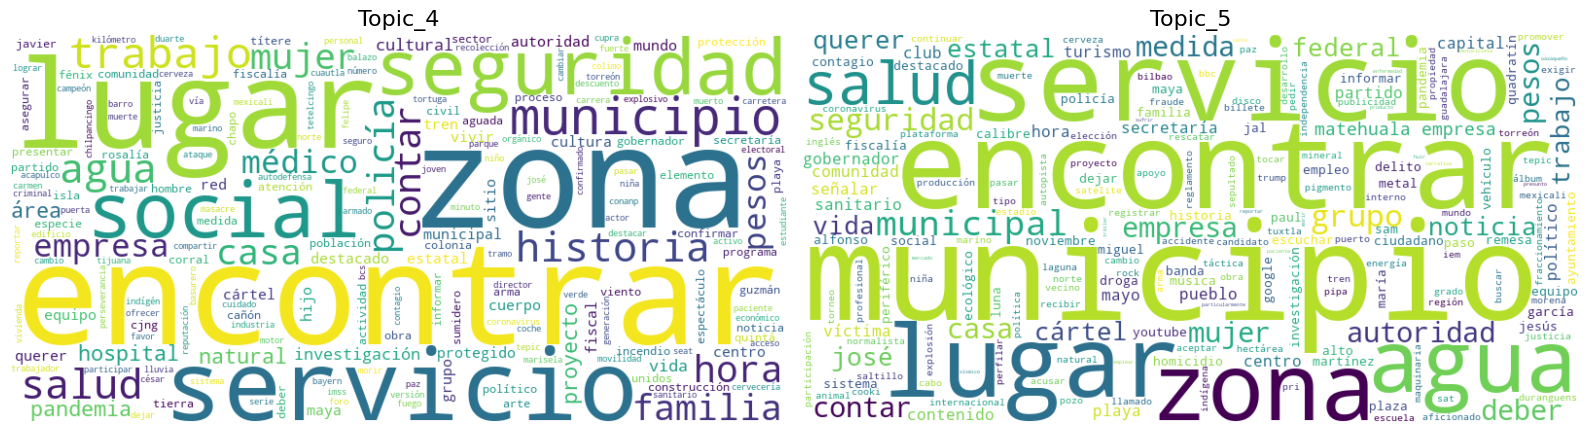

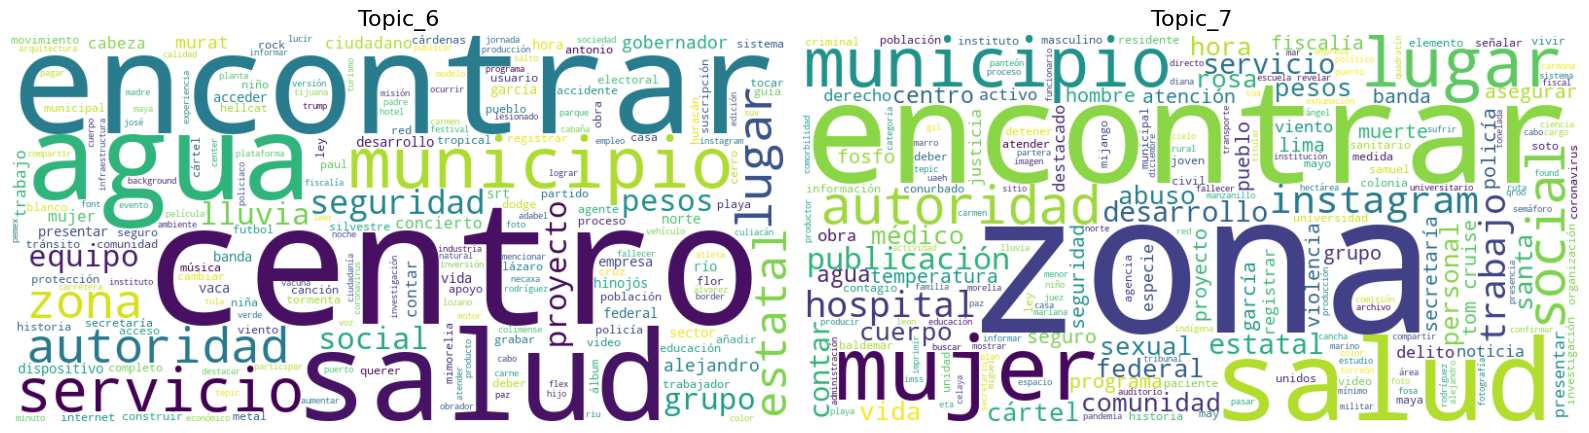

In [20]:
topic_cols_2020 = [col for col in df_2020.columns if col.startswith("Topic_")]
for i in range(0, len(topic_cols_2020), 2):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    for j in range(2):
        if i + j < len(topic_cols_2020):
            col = topic_cols_2020[i + j]
            text = ' '.join(df_2020[col].dropna().tolist())
            wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)
            axes[j].imshow(wordcloud, interpolation='bilinear')
            axes[j].axis('off')
            axes[j].set_title(col, fontsize=16)
    plt.tight_layout()
    plt.show()

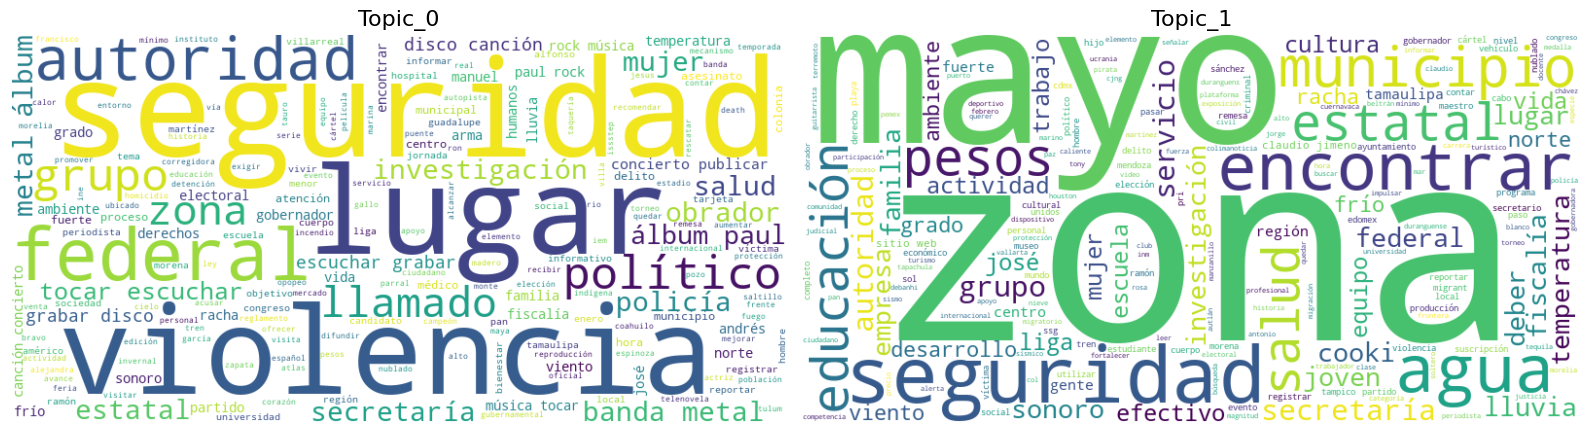

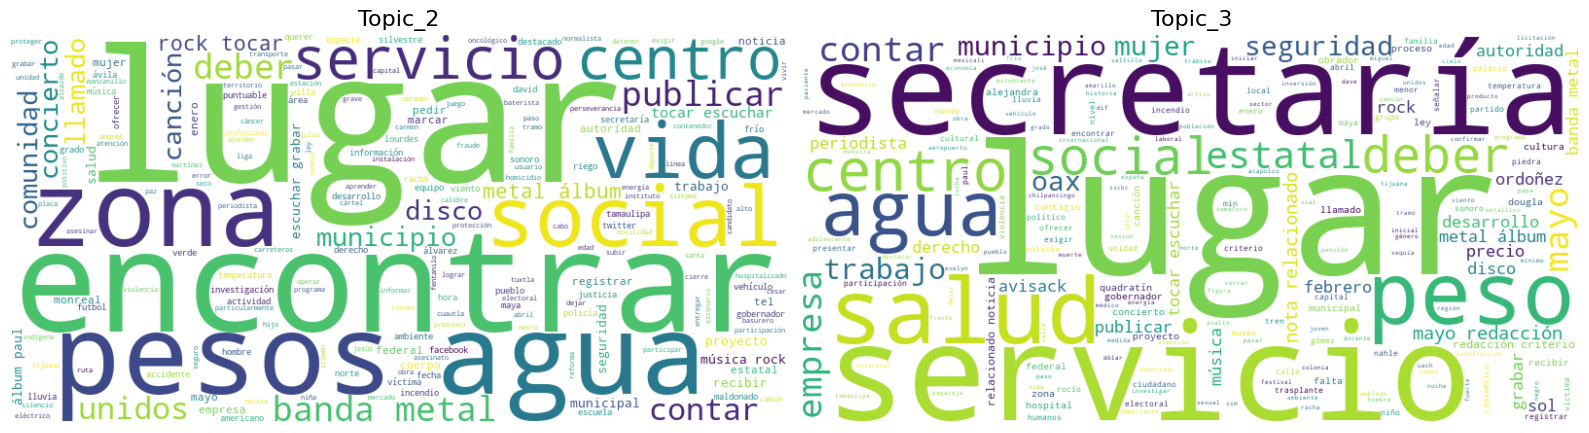

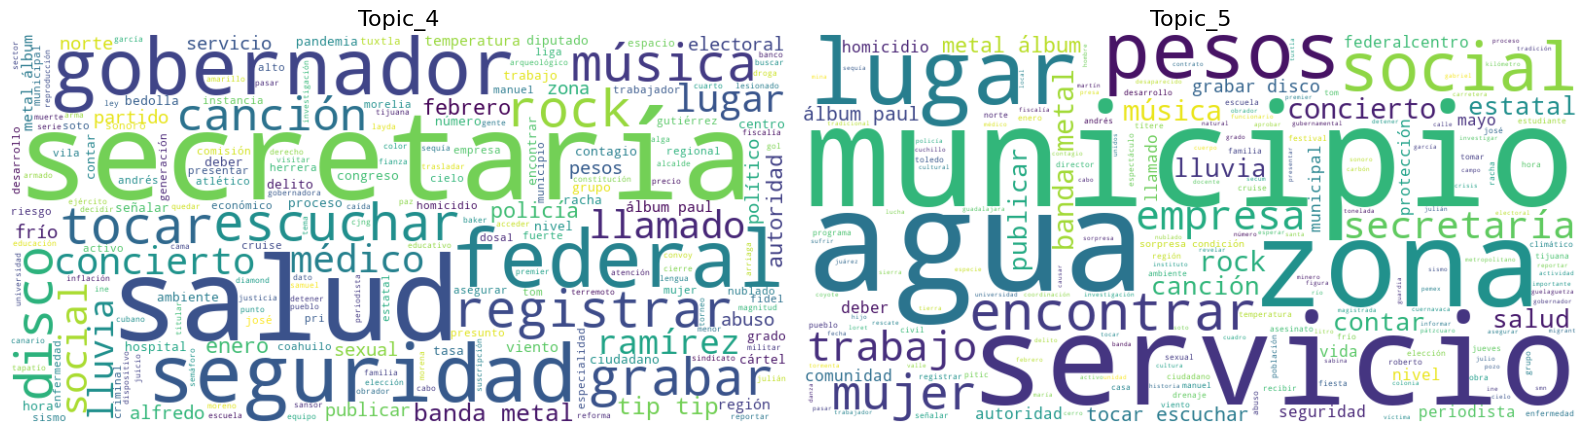

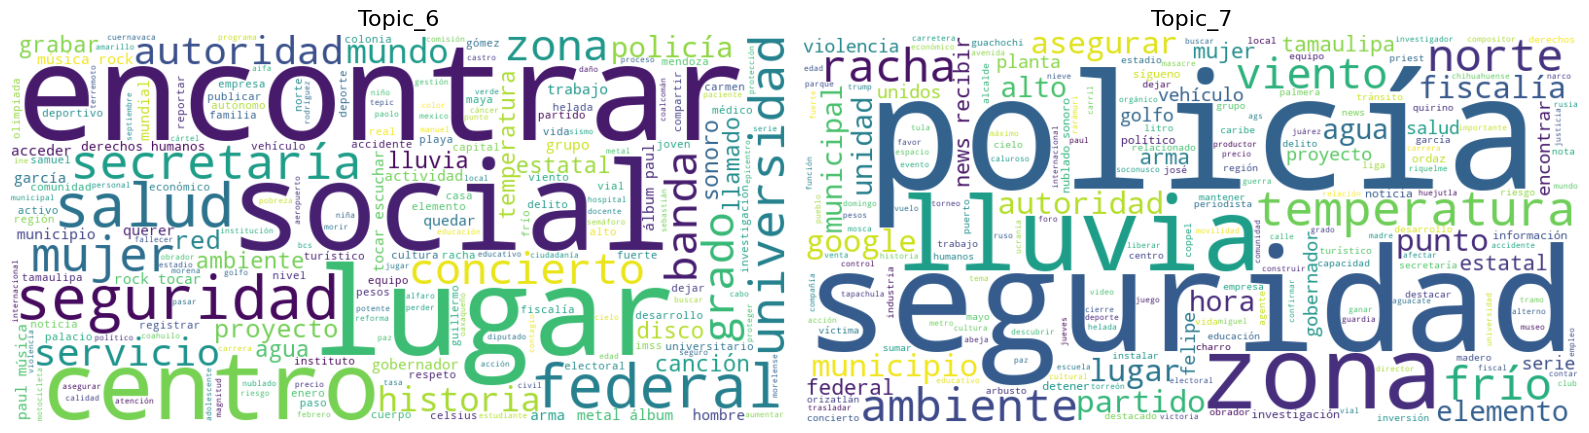

In [21]:
topic_cols_2022 = [col for col in df_2022.columns if col.startswith("Topic_")]
for i in range(0, len(topic_cols_2020), 2):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    for j in range(2):
        if i + j < len(topic_cols_2022):
            col = topic_cols_2022[i + j]
            text = ' '.join(df_2022[col].dropna().tolist())
            wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)
            axes[j].imshow(wordcloud, interpolation='bilinear')
            axes[j].axis('off')
            axes[j].set_title(col, fontsize=16)
    plt.tight_layout()
    plt.show()